# RFM Analysis on Olist E-commerce Dataset 
**Note:** To use the Table of Contents navigation, please download the notebook, as this functionality is not supported within the GitHub interface.

<a id="top"></a>
# Table of Content

*  [1. Notebook Overview](#Notebook-Overview)
*  [2. Importing Libaries and Dataset](#Importing-Libaries-and-Dataset)
    * [2.1 Check Data Quality - Nulls and Duplicate Rows](#Data-Quality)
    * [2.2 Dropping Nulls](#Dropping-Nulls)
    * [2.3 Merging Tables](#Merging-Tables)
    * [2.4 Exploring Order Payments Table](#Exploring-Order-Payments-Table)
    * [2.5 Merging Table V2](#Merging-Table-V2)
    * [2.6 Convert Time Column to pd.datetime](#Convert-Time-Column-to-pd.datetime)
* [3. RFM Analysis](#RFM-Analysis)
    * [3.1 Creating RFM Variables](#Creating-RFM-Variables)
    * [3.2 Merging Recency, Frequency, and Monetary Values](#Merging-RFM)
    * [3.3 Plotting RFM Value Distribution](#Plotting-RFM-Value-Distribution)
    * [3.4 Checking For Outliers](#Checking-For-Outliers)
* [4. Creating RFM Segments](#Creating-RFM-Segments) 
* [5. Power BI Exports](#Power-BI-Exports)   

<a name='Notebook-Overview'></a>
# Notebook Overview
This Jupyter Notebook is designed to perform an in-depth RFM (Recency, Frequency, Monetary) Analysis on an e-commerce dataset. The primary objective is to segment customers based on their purchasing behavior and provide actionable insights for targeted marketing strategies.

## Key Features:
* **Data Cleaning and Preparation:** Import and preprocess raw data to ensure it is ready for analysis. This includes handling missing values, correcting data types, and deriving necessary columns.
* **RFM Calculation:** Compute the Recency, Frequency, and Monetary values for each customer. This involves calculating the time since the last purchase, the total number of transactions, and the total amount spent by each customer.
* **Customer Segmentation:** Segment customers into different groups based on their RFM scores. These segments help in identifying high-value customers, at-risk customers, and other important customer groups.
* **Data Visualization:** Create visualizations to illustrate the distribution of RFM values and the composition of different customer segments. These visualizations aid in understanding the customer base and deriving insights.
* **Insights and Recommendations:** Provide data-driven insights and recommendations for marketing strategies. These insights are based on the RFM segments and are aimed at improving customer retention and increasing sales.

## Tools and Libraries:
* **Python:** The primary programming language used for data manipulation and analysis.
* **Pandas:** For data cleaning and preparation.
* **Matplotlib and Seaborn:** For creating visualizations.

## Objective:
The objective of this notebook is to showcase the process of performing RFM Analysis and to demonstrate proficiency in data manipulation, analysis, and visualization using Python. The insights derived from this analysis can help businesses better understand their customers and tailor their marketing efforts to maximize customer lifetime value.

## Methodology Overview 
The RFM model categorizes customers based on:

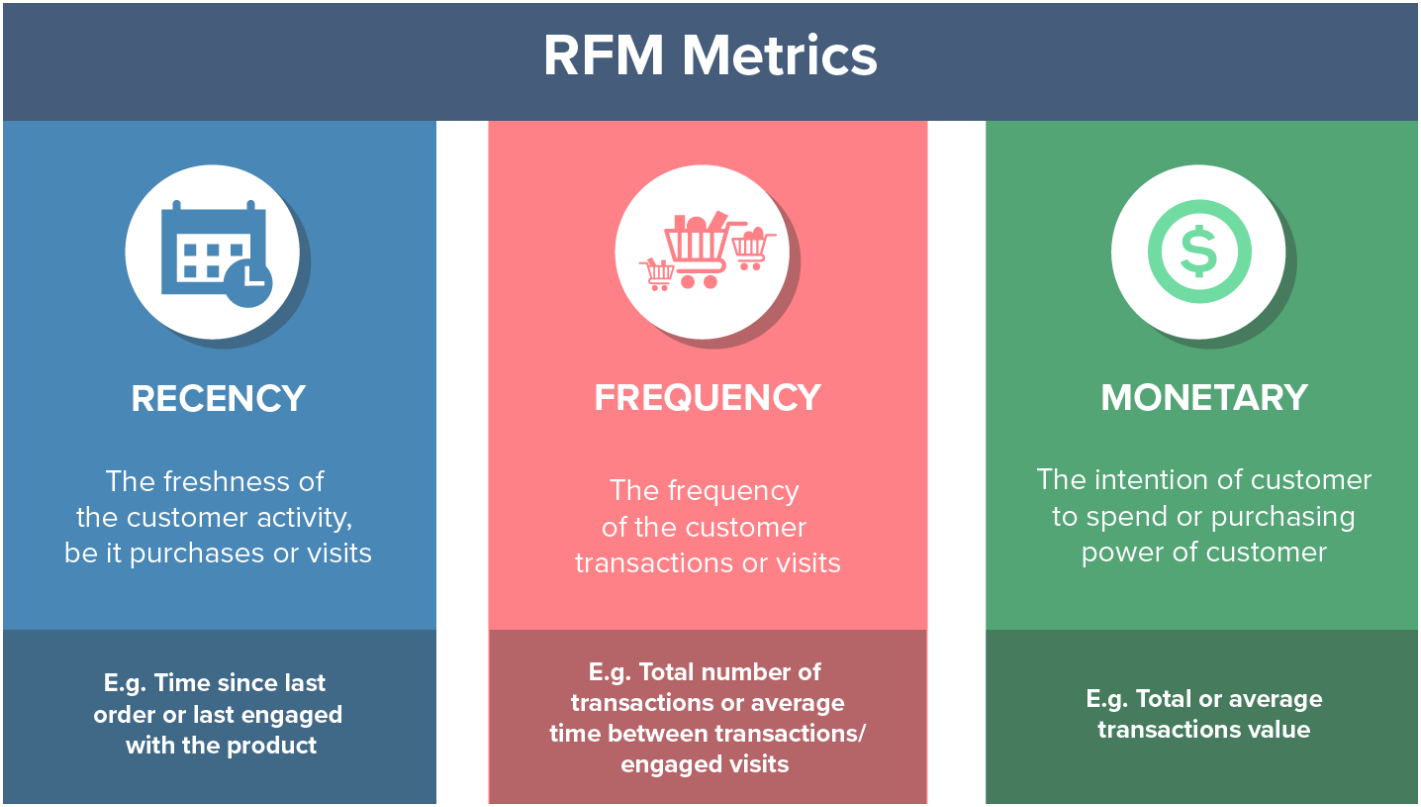

Customers are scored on each of these dimensions, and combined scores are used for segmentation.

<a name='Importing-Libaries-and-Dataset'></a>
# Importing Libaries and Dataset
[Go to TOC](#top)

In [53]:
# importing necessary libaries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")

In [54]:
# loading data 
customers = pd.read_csv("data\customers.csv")
orders = pd.read_csv("data\orders.csv")
order_payments = pd.read_csv("data\order_payments.csv")

# Understanding the Dataset (EDA & Data Preprocessing)
[Go to TOC](#top)

**Notes:**

* An order might have multiple items.

In [55]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [56]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [57]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


<a name='Data-Quality'></a>
## Check Data Quality - Nulls and Duplicate Rows 

[Go to TOC](#top)

**Notes:**

* `order_id` in orders table is unique

* `order_status` in orders table is SCD type 1

In [58]:
# Collections for each dataset
datasets = [customers, orders, order_payments]
            
names = ['customers', 'orders', 'order_reviews']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_rows'] = [df.isnull().any(axis=1).sum() for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_rows,null_amount,qty_null_columns,null_columns
0,customers,99441,5,0,0,0,
1,orders,99441,8,2980,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
2,order_reviews,103886,5,0,0,0,


<a name='Dropping-Nulls'></a>
## Dropping Nulls
 
[Go to TOC](#top)

In [59]:
for i in datasets:
    i.dropna(inplace=True)

for i in datasets:
    i.drop(i[i.duplicated()].index, axis=0, inplace=True)

In [60]:
# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_rows'] = [df.isnull().any(axis=1).sum() for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_rows,null_amount,qty_null_columns,null_columns
0,customers,99441,5,0,0,0,
1,orders,96461,8,0,0,0,
2,order_reviews,103886,5,0,0,0,


<a name='Merging-Tables'></a>
## Merging Tables 
[Go to TOC](#top)

In [61]:
merged_df = pd.merge(customers, orders, on="customer_id", how="inner")
merged_df.shape

(96461, 12)

In [62]:
merged_df= merged_df.merge(order_payments, on="order_id", how="inner")
merged_df.shape

(100739, 16)

After merging the customers and orders dataframes on `customer_id` using an inner join, the resulting dataframe `merged_df` contains 96,461 rows and 12 columns. When we further merge `merged_df` with the `order_payments` dataframe on `order_id` using an inner join, the number of rows increases to 100,739, and the number of columns to 16.

The increase in rows indicates that there are multiple matching rows in the `order_payments` table for some rows in the orders table. This scenario is common in one-to-many relationships, where each order can have multiple associated payment records.

Below is a visual example of the scenario. 

![alt text](<left join.PNG>)

<a name='Exploring-Order-Payments-Table'></a>
## Exploring Order Payments Table
[Go to TOC](#top)

Let's explore the `order_payments` table to address the one-to-many relationship with the orders table. We aim to aggregate payment data so that each `order_id` corresponds to a single record with the total payment amount.

In [63]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [64]:
order_payments.shape

(103886, 5)

In [65]:
order_payments["order_id"].nunique()

99440

**Conclusion:** The `order_payments` table contains 103,886 rows, but only 99,400 unique `order_ids` due to the presence of `payment_sequential`, which indicates multiple payments per order. To ensure that each `order_id` is unique, we need to create a new table where the payment values are fully aggregated per order.

In [66]:
agg_order_payments = order_payments.groupby("order_id")["payment_value"].sum().reset_index()
agg_order_payments.head()

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


<a name='Merging-Table-V2'></a>
## Merging Table V2
[Go to TOC](#top)

In [67]:
merged_df = pd.merge(customers, orders, on="customer_id", how="inner")
merged_df.shape

(96461, 12)

In [68]:
merged_df= merged_df.merge(agg_order_payments, on="order_id", how="left")
merged_df.shape

(96461, 13)

We created the `agg_order_payments` table by aggregating payment data for each `order_id`. The subsequent merge with the orders table was successful, and no additional rows were added, indicating the one-to-many relationship issue was resolved.

In [69]:
merged_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


In [70]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96461 entries, 0 to 96460
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    96461 non-null  object 
 1   customer_unique_id             96461 non-null  object 
 2   customer_zip_code_prefix       96461 non-null  int64  
 3   customer_city                  96461 non-null  object 
 4   customer_state                 96461 non-null  object 
 5   order_id                       96461 non-null  object 
 6   order_status                   96461 non-null  object 
 7   order_purchase_timestamp       96461 non-null  object 
 8   order_approved_at              96461 non-null  object 
 9   order_delivered_carrier_date   96461 non-null  object 
 10  order_delivered_customer_date  96461 non-null  object 
 11  order_estimated_delivery_date  96461 non-null  object 
 12  payment_value                  96460 non-null 

The `order_purchase_timestamp` column is currently of object data type. We need to convert it to a datetime data type.

<a name='Convert-Time-Column-to-pd.datetime'></a>
## Convert Time Column to pd.datetime
[Go to TOC](#top)

In [71]:
merged_df["order_purchase_timestamp"] = pd.to_datetime(merged_df["order_purchase_timestamp"])

In [72]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96461 entries, 0 to 96460
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96461 non-null  object        
 1   customer_unique_id             96461 non-null  object        
 2   customer_zip_code_prefix       96461 non-null  int64         
 3   customer_city                  96461 non-null  object        
 4   customer_state                 96461 non-null  object        
 5   order_id                       96461 non-null  object        
 6   order_status                   96461 non-null  object        
 7   order_purchase_timestamp       96461 non-null  datetime64[ns]
 8   order_approved_at              96461 non-null  object        
 9   order_delivered_carrier_date   96461 non-null  object        
 10  order_delivered_customer_date  96461 non-null  object        
 11  order_estimated

 <a name='RFM Analysis'></a>
# RFM Analysis
[Go to TOC](#top)

<a name='Creating-RFM-Variables'></a>
## Creating RFM Variables
[Go to TOC](#top)

For our analysis, let's determine the current date, which we will set as two days after the last date in our dataset:

In [73]:
present_day = merged_df['order_purchase_timestamp'].max() + dt.timedelta(days=2)
present_day

Timestamp('2018-08-31 15:00:37')

In [74]:
print("Latest date in dataset: ", merged_df['order_purchase_timestamp'].max())

Latest date in dataset:  2018-08-29 15:00:37


Let's define the "Recency", "Frequency", and "Monetary" values for our analysis:

**Recency:** The number of days since the customer's last purchase.

**Frequency** The total number of purchases made by the customer.

**Monetary:** The total amount spent by the customer.

In [75]:
recency_df= pd.DataFrame(merged_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
recency_df.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [76]:
recency_df['Recency']= recency_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)
recency_df.head()

,customer_unique_id,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,116
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,538
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,322
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,289


In [77]:
frequency_df = pd.DataFrame(merged_df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency_df.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [78]:
monetary_df = merged_df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary_df.columns = ['customer_unique_id', 'Monetary']
monetary_df.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


 <a name='Merging-RFM'></a>
## Merging Recency, Frequency, and Monetary Values
[Go to TOC](#top)

In [79]:
RF_df = recency_df.merge(frequency_df, on='customer_unique_id')
RFM_df = RF_df.merge(monetary_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
RFM_df.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89


In [80]:
RFM_df.shape

(93342, 4)

 <a name='Plotting-RFM-Value-Distribution'></a>
## Plotting RFM Value Distribution
[Go to TOC](#top)

In [81]:
RFM_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,93342.0,238.927632,152.584210,2.0,115.00,220.00,347.000,715.00
Frequency,93342.0,1.033415,0.209091,1.0,1.00,1.00,1.000,15.00
Monetary,93342.0,165.195548,226.329058,0.0,63.05,107.78,182.535,13664.08


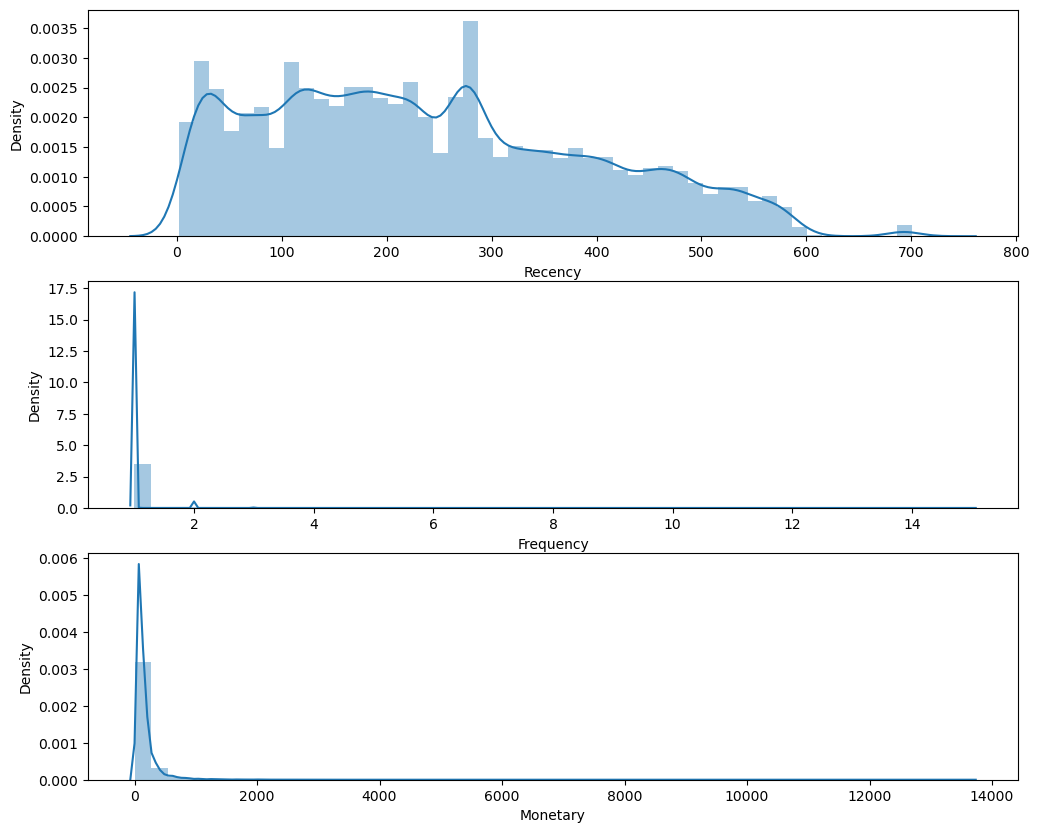

In [82]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df['Monetary'])
plt.show()

In [83]:
RFM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93342 entries, 0 to 93341
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93342 non-null  object 
 1   Recency             93342 non-null  int64  
 2   Frequency           93342 non-null  int64  
 3   Monetary            93342 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


<a name='Checking-For-Outliers'></a>
## Checking For Outliers
[Go to TOC](#top)

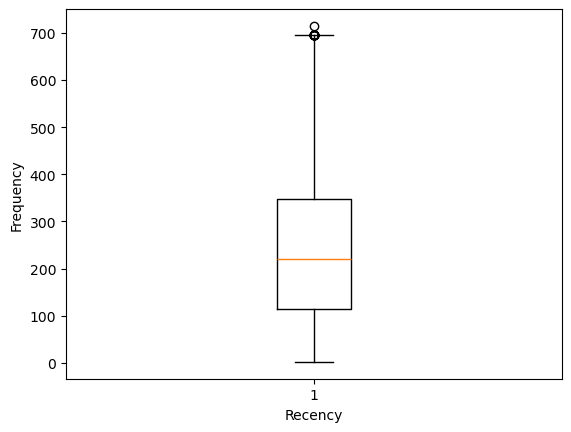

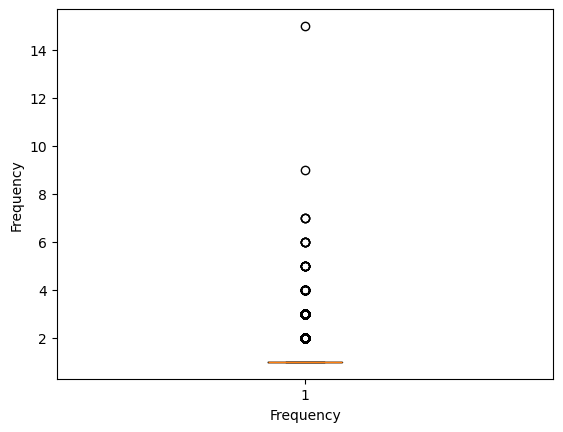

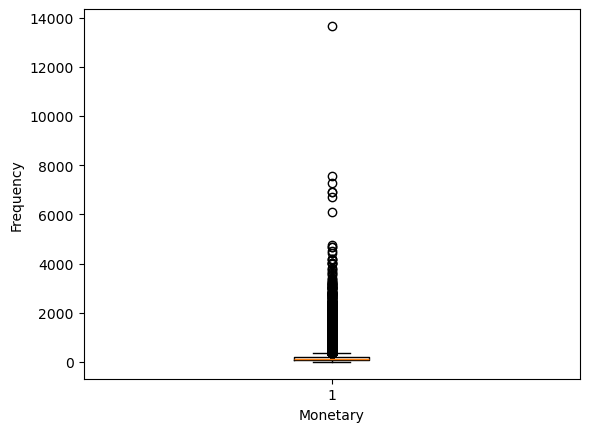

In [84]:
for i in ["Recency", "Frequency", "Monetary"]:
    plt.figure()
    plt.tight_layout()
    plt.gca().set(xlabel= i, ylabel='Frequency')
    plt.boxplot(RFM_df[i])

**Checking for Outliers within +/- 5% Boundaries**

When we check for outliers within +/- 5% boundaries, we're identifying prices that are significantly higher or lower than most of the prices in the dataset. Here’s the process:

1. **Find Percentiles:**

    * 5th Percentile: The price below which 5% of the prices fall.
    * 95th Percentile: The price below which 95% of the prices fall.


2. **Set Boundaries:**

* Define a range that is considered normal, starting slightly below the 5th percentile and ending slightly above the 95th percentile.
* Prices outside this range are considered outliers.

3. **Check for Outliers:**

* Examine each price in the list. If a price falls outside the normal range, it is marked as an outlier. 

By setting these boundaries, we can effectively identify prices that are unusually high or low compared to the rest of the dataset.

In [85]:
# This function calculates the lower and upper bounds for outliers using the IQR method and then identifies outliers in the specified column of a DataFrame. 
# It returns the number of outliers and their indexes for further investigation.

def num_outlier(df_in, col_name):
    # Calculate the 5th and 95th percentiles of the column
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    
    # Calculate the Interquartile Range (IQR)
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds for outliers
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    # Identify outliers using the lower and upper bounds
    outliers_df = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    
    # Return the number of outliers and their indexes
    return print("Number of outliers in {} column: ".format(col_name), len(outliers_df)), print("Indexes: ", outliers_df.index)

In [86]:
for i in ["Recency", "Frequency", "Monetary"]:
    num_outlier(RFM_df, i)
    print("*"*40)

Number of outliers in Recency column:  0
Indexes:  Index([], dtype='int64')
****************************************
Number of outliers in Frequency column:  2800
Indexes:  Index([  104,   243,   305,   404,   419,   428,   438,   467,   469,   501,
       ...
       92732, 92746, 92802, 92902, 92907, 92975, 93069, 93171, 93189, 93298],
      dtype='int64', length=2800)
****************************************
Number of outliers in Monetary column:  889
Indexes:  Index([  130,   256,   289,   416,   437,   438,   570,   607,   789,   863,
       ...
       92802, 92879, 92920, 92985, 92990, 93065, 93130, 93247, 93330, 93337],
      dtype='int64', length=889)
****************************************


We have identified 2,800 outliers in the Frequency column and 889 outliers in the Monetary column.

In [87]:
RFM_df.shape

(93342, 4)

Let's remove outliers that fall within the +/- 5% boundaries.

In [88]:
# This function calculates the lower and upper bounds for outliers using the IQR method,
# identifies outliers in the specified column of a DataFrame, removes them from the DataFrame,
# and prints a message confirming the removal. Finally, it returns the modified DataFrame without outliers.

def remove_outlier(df_in, col_name):
    # Calculate the 5th and 95th percentiles of the column
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    
    # Calculate the Interquartile Range (IQR)
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds for outliers
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    # Identify indexes of outliers using the lower and upper bounds
    index_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)].index
    
    # Remove outliers from the DataFrame
    df_in.drop(index_outliers, axis=0, inplace=True)
    
    # Print a message indicating that outliers have been removed
    print("Outliers in the {} column have been removed".format(col_name))
    
    # Return the modified DataFrame
    return df_in

In [89]:
for i in ["Recency", "Monetary"]:
    remove_outlier(RFM_df, i)
    print("*"*40)

Outliers in the Recency column have been removed
****************************************
Outliers in the Monetary column have been removed
****************************************


In [90]:
RFM_df.shape

(92453, 4)

In [91]:
RFM_df2= RFM_df.copy()
RFM_df2= RFM_df2.set_index('customer_unique_id')

In [92]:
# new df without outliers 
RFM_df2.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
0000f46a3911fa3c0805444483337064,538,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
0004aac84e0df4da2b147fca70cf8255,289,1,196.89


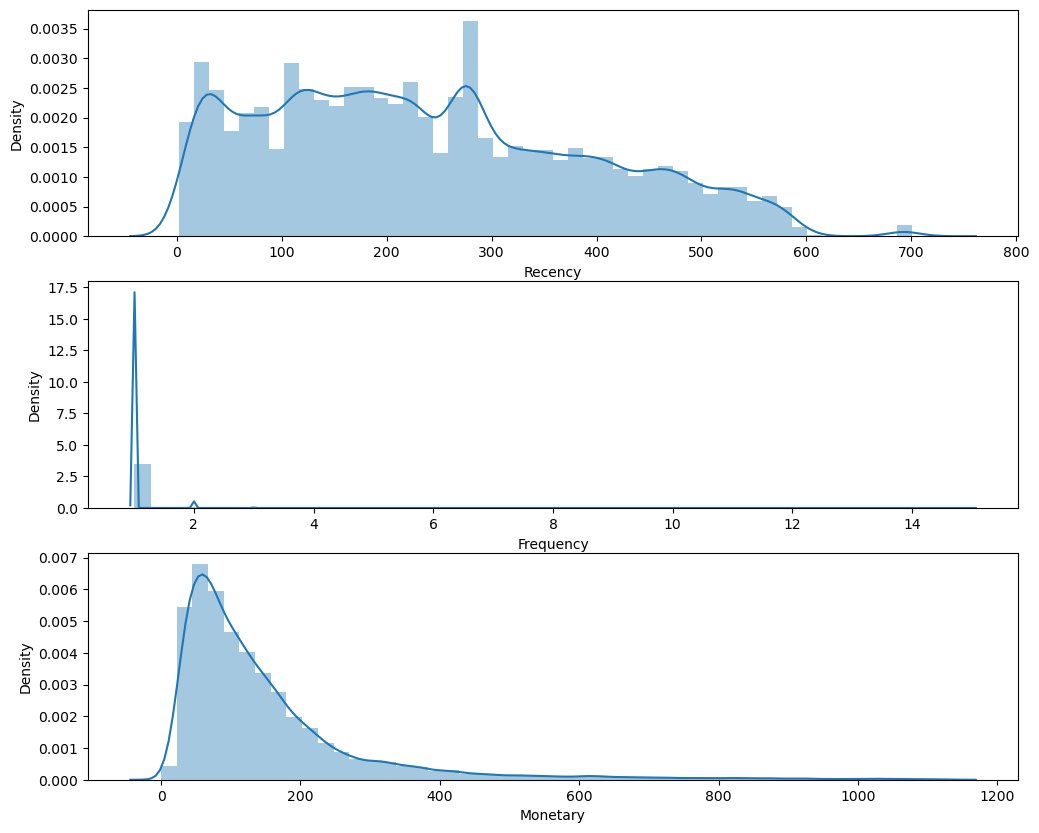

In [93]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1); sns.distplot(RFM_df2['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_df2['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_df2['Monetary'])
plt.show()

 <a name='Creating-RFM-Segments'></a>
# Creating RFM Segments

[Go to TOC](#top)

This code defines a mapping between certain customer segments and their corresponding labels. Each key in the `seg_map` dictionary is a regular expression pattern that matches specific customer IDs, and the corresponding value is the label or segment name for those customers.

For example:

* Customers whose IDs match the pattern 111, 112, 121, 131, 141, or 151 are labeled as Lost customers.
* Customers whose IDs match the pattern 332, 322, 233, 232, 223, 222, 132, 123, 122, 212, or 211 are labeled as Hibernating customers.

And so on for the other patterns and labels. This mapping can be used to categorize customers based on their IDs into different segments for analysis or marketing purposes.

In [94]:
seg_map= {
    r'111|112|121|131|141|151': 'Lost customers',
    r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers', 
    r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
    r'331|321|312|221|213|231|241|251': 'About To Sleep',
    r'535|534|443|434|343|334|325|324': 'Need Attention',
    r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
    r'512|511|422|421|412|411|311': 'New Customers',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
    r'543|444|435|355|354|345|344|335': 'Loyal',
    r'555|554|544|545|454|455|445': 'Champions'
}

In [95]:
# Need to add an index to reconnect later
RFM_df2 = RFM_df2.reset_index().reset_index()
RFM_df2_without_index = RFM_df2[["index", "customer_unique_id"]]
RFM_df2.head()

,index,customer_unique_id,Recency,Frequency,Monetary
0,0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19
2,2,0000f46a3911fa3c0805444483337064,538,1,86.22
3,3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62
4,4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89


In [96]:
# needed to remove customer_unique_id, otherwise quantiles wouldn't work
RFM_df2 = RFM_df2[["index","Recency", "Frequency", "Monetary"]]
RFM_df2.head()

,index,Recency,Frequency,Monetary
0,0,113,1,141.90
1,1,116,1,27.19
2,2,538,1,86.22
3,3,322,1,43.62
4,4,289,1,196.89


This code calculates the RFM (Recency, Frequency, Monetary) scores for each customer based on their transaction data.

It first calculates the quantiles for each RFM value, then defines functions to assign scores based on these quantiles.

Finally, it applies these functions to calculate the scores and concatenates them to create the final RFM score for each customer.

The `RScore` and `FMScore` functions are used to assign scores to customers based on their Recency, Frequency, and Monetary values. These scores help categorize customers into different segments for RFM analysis.

**RScore Function (Recency Score):**

* **Inputs:**
    * x: The value of Recency for a specific customer.
    * p: The column name (in this case, 'Recency') to retrieve the quantiles from the quantiles dictionary.
    * d: The quantiles dictionary containing the 20th, 40th, 60th, and 80th percentile values for Recency.
    
* **Logic:**
    * If the customer's Recency value is less than or equal to the 20th percentile value (d[p][0.20]), assign a score of 5.
    * If the Recency value is less than or equal to the 40th percentile value but greater than the 20th percentile value, assign a score of 4.
    * Continue this pattern for the 60th and 80th percentile values, assigning scores of 3 and 2 respectively.
    * If the Recency value is greater than the 80th percentile value, assign a score of 1.

**FMScore Function (Frequency and Monetary Score):**
* **Inputs:**
    * x: The value of Frequency or Monetary for a specific customer.
    * p: The column name ('Frequency' or 'Monetary') to retrieve the quantiles from the quantiles dictionary.
    * d: The quantiles dictionary containing the 20th, 40th, 60th, and 80th percentile values for Frequency or Monetary.


* **Logic:**
    * Follows a similar logic to RScore, but with a different scoring pattern.
    * Assigns a score of 1 for values less than or equal to the 20th percentile, 2 for values between the 20th and 40th percentile, and so on, up to a score of 5 for values greater than the 80th percentile.
    * These functions help categorize customers based on their Recency, Frequency, and Monetary values, providing a numerical representation of their engagement with the business.

In [97]:
# Calculate quantiles for RFM values (Recency, Frequency, Monetary)
quantiles = RFM_df2.quantile(q=[0.20,0.4, 0.6, 0.8])
# Convert quantiles to a dictionary for easier access
quantiles = quantiles.to_dict()

# Define a function to calculate the Recency score
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 2
    else:
        return 1

# Define a function to calculate the Frequency and Monetary scores
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]: 
        return 3
    elif x <= d[p][0.80]: 
        return 4
    else:
        return 5

# Apply the RScore function to calculate the Recency score
RFM_df2['Recency Score'] = RFM_df2['Recency'].apply(RScore, args=('Recency',quantiles))
# Apply the FMScore function to calculate the Frequency score
RFM_df2['Frequency Score'] = RFM_df2['Frequency'].apply(FMScore, args=('Frequency',quantiles))
# Apply the FMScore function to calculate the Monetary score
RFM_df2['Monetary Score'] = RFM_df2['Monetary'].apply(FMScore, args=('Monetary',quantiles))

# Concatenate the Recency, Frequency, and Monetary scores to create the RFM Score
RFM_df2['RFM Score'] = RFM_df2['Recency Score'].astype(str)+ RFM_df2['Frequency Score'].astype(str) + RFM_df2['Monetary Score'].astype(str)

# Return the DataFrame with the calculated RFM scores
RFM_df2

,index,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score
0,0,113,1,141.90,4,1,4,414
1,1,116,1,27.19,4,1,1,411
2,2,538,1,86.22,1,1,2,112
3,3,322,1,43.62,2,1,1,211
4,4,289,1,196.89,2,1,4,214
...,...,...,...,...,...,...,...,...
92448,92448,246,1,167.32,3,1,4,314
92449,92449,263,1,84.58,3,1,2,312
92450,92450,569,1,112.46,1,1,3,113
92451,92451,120,1,133.69,4,1,4,414


In [98]:
# Concatenate the Recency, Frequency, and Monetary scores to create the RFM Score
RFM_df2['Segment'] = RFM_df2['Recency Score'].astype(str) + RFM_df2['Frequency Score'].astype(str) + RFM_df2['Monetary Score'].astype(str)

# Replace the concatenated scores with the corresponding segment names using the seg_map dictionary
RFM_df2['Segment'] = RFM_df2['Segment'].replace(seg_map, regex=True)

# Display the first few rows of the DataFrame to show the updated 'Segment' column
RFM_df2.head()

,index,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,Segment
0,0,113,1,141.90,4,1,4,414,Promising
1,1,116,1,27.19,4,1,1,411,New Customers
2,2,538,1,86.22,1,1,2,112,Lost customers
3,3,322,1,43.62,2,1,1,211,Hibernating customers
4,4,289,1,196.89,2,1,4,214,Cannot Lose Them


In [99]:
RFM_df2.shape

(92453, 9)

In [100]:
# Re match the unique_customer_id
RFM_df2 = RFM_df2.merge(RFM_df2_without_index, on="index")

# moving customer_unique_id to index 0
column_to_move = 'customer_unique_id'
after_which_column = 'index'

# Get the current index of the 'product_id' column
idx = list(RFM_df2.columns).index(after_which_column) + 1

# Insert the 'product_category_name' column after 'product_id'
RFM_df2.insert(idx, column_to_move, RFM_df2.pop(column_to_move))

# Dropping Index Column
RFM_df2 = RFM_df2.drop("index", axis=1)

RFM_df2.head()

,customer_unique_id,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them


In [101]:
RFM_df2.shape

(92453, 9)

In [102]:
RFMStats = RFM_df2[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(['mean','median', 'min', 'max', 'count'])
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         269.063884  269.0  179  383   7091  1.000423    1.0   
At Risk                341.883830  329.0  270  603    637  2.078493    2.0   
Cannot Lose Them       412.293728  410.0  270  696  17523  1.019688    1.0   
Champions               89.815544   89.0    2  178    965  2.175130    2.0   
Hibernating customers  317.699235  314.0  270  383   7451  1.000000    1.0   
Lost customers         474.418340  467.0  384  715   7721  1.001166    1.0   
Loyal                  217.995927  214.0  179  269    491  2.087576    2.0   
New Customers          118.383951  117.0    2  269  18057  1.000000    1.0   
Potential Loyalist     131.864516  134.5    2  268    310  2.016129    2.0   
Promising              134.657342  134.0    2  269  32207  1.000000    1.0   

                                        Monetary                            \
                      min max  count        mean   median     min      max   
Segment                                                                      
About To Sleep          1   2   7091   88.262313   86.150   39.34   131.03   
At Risk                 2   6    637  243.222370  185.090   56.00  1044.13   
Cannot Lose Them        1   4  17523  235.208211  178.260   86.67  1124.96   
Champions               2  15    965  329.199751  265.050  131.08  1122.72   
Hibernating customers   1   1   7451   55.840373   56.780   10.07    86.64   
Lost customers          1   3   7721   55.090600   55.000    0.00    86.64   
Loyal                   2   7    491  311.710428  256.980  131.20  1078.16   
New Customers           1   1  18057   51.113300   48.930    9.59    86.64   
Potential Loyalist      2   3    310   96.764613   99.625   35.94   130.64   
Promising               1   1  32207  208.220812  158.680   86.66  1125.00   

                              
                       count  
Segment                       
About To Sleep          7091  
At Risk                  637  
Cannot Lose Them       17523  
Champions                965  
Hibernating customers   7451  
Lost customers          7721  
Loyal                    491  
New Customers          18057  
Potential Loyalist       310  
Promising              32207

In [103]:
RFMStats['Ratio']= (100*RFMStats['Monetary']["count"]/RFMStats['Monetary']["count"].sum()).round(2)
RFMStats

Recency                         Frequency         \
                             mean median  min  max  count      mean median   
Segment                                                                      
About To Sleep         269.063884  269.0  179  383   7091  1.000423    1.0   
At Risk                341.883830  329.0  270  603    637  2.078493    2.0   
Cannot Lose Them       412.293728  410.0  270  696  17523  1.019688    1.0   
Champions               89.815544   89.0    2  178    965  2.175130    2.0   
Hibernating customers  317.699235  314.0  270  383   7451  1.000000    1.0   
Lost customers         474.418340  467.0  384  715   7721  1.001166    1.0   
Loyal                  217.995927  214.0  179  269    491  2.087576    2.0   
New Customers          118.383951  117.0    2  269  18057  1.000000    1.0   
Potential Loyalist     131.864516  134.5    2  268    310  2.016129    2.0   
Promising              134.657342  134.0    2  269  32207  1.000000    1.0   

                                        Monetary                            \
                      min max  count        mean   median     min      max   
Segment                                                                      
About To Sleep          1   2   7091   88.262313   86.150   39.34   131.03   
At Risk                 2   6    637  243.222370  185.090   56.00  1044.13   
Cannot Lose Them        1   4  17523  235.208211  178.260   86.67  1124.96   
Champions               2  15    965  329.199751  265.050  131.08  1122.72   
Hibernating customers   1   1   7451   55.840373   56.780   10.07    86.64   
Lost customers          1   3   7721   55.090600   55.000    0.00    86.64   
Loyal                   2   7    491  311.710428  256.980  131.20  1078.16   
New Customers           1   1  18057   51.113300   48.930    9.59    86.64   
Potential Loyalist      2   3    310   96.764613   99.625   35.94   130.64   
Promising               1   1  32207  208.220812  158.680   86.66  1125.00   

                              Ratio  
                       count         
Segment                              
About To Sleep          7091   7.67  
At Risk                  637   0.69  
Cannot Lose Them       17523  18.95  
Champions                965   1.04  
Hibernating customers   7451   8.06  
Lost customers          7721   8.35  
Loyal                    491   0.53  
New Customers          18057  19.53  
Potential Loyalist       310   0.34  
Promising              32207  34.84

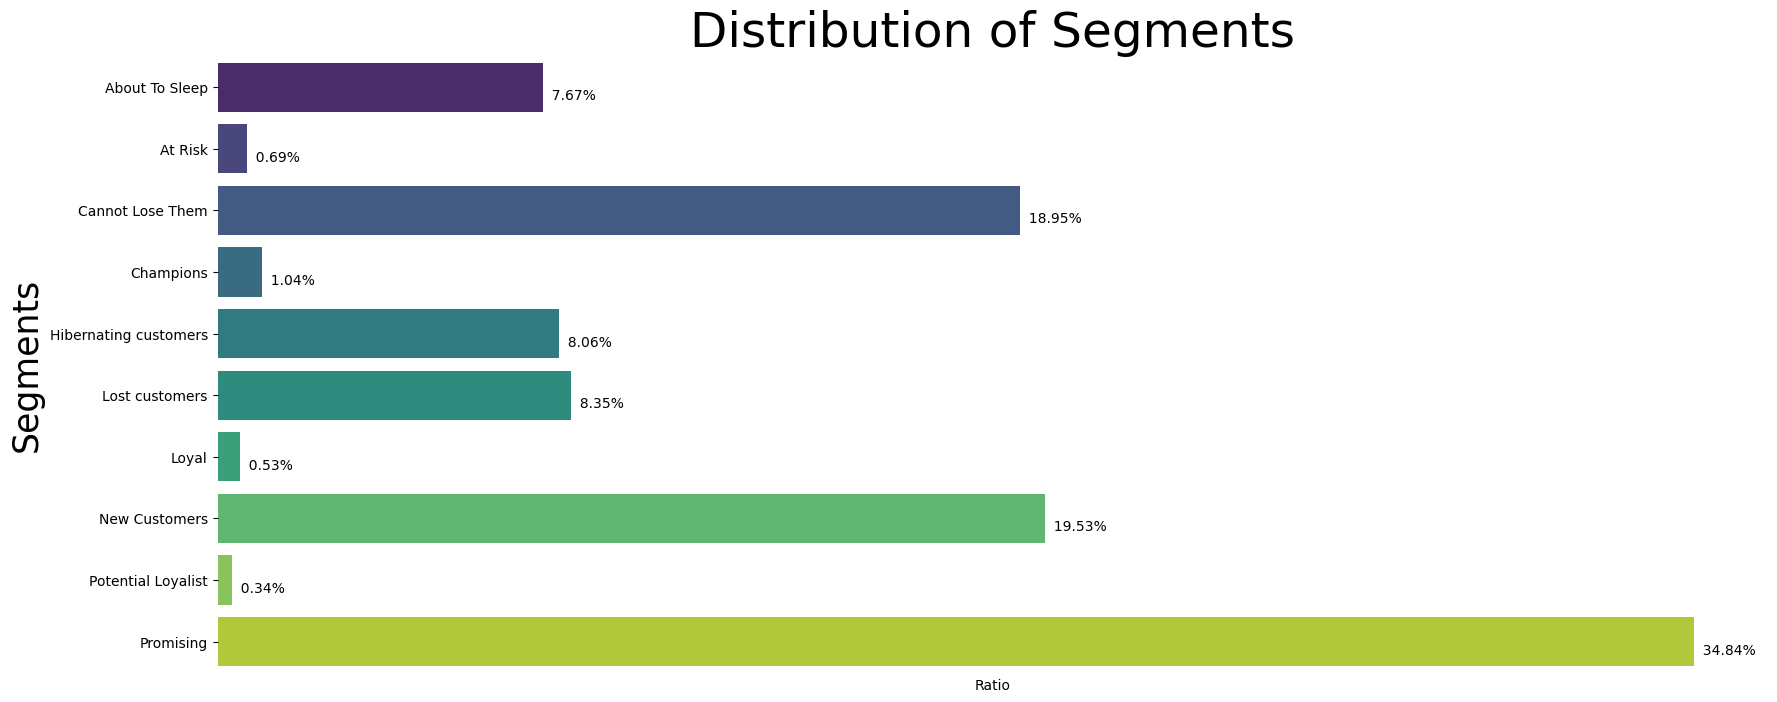

In [104]:
plt.figure(figsize=(20,8))
#plt.rc('font', size=20)
per= sns.barplot(x=RFMStats['Ratio'], y=RFMStats.index, data=RFMStats, palette="viridis")
sns.despine(bottom = True, left = True)
for i, v in enumerate(RFMStats['Ratio']):
    per.text(v, i+.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
per.set_ylabel('Segments', fontsize=25)
per.set(xticks=[])
plt.title('Distribution of Segments', fontsize=35)
plt.show()

</a> <a name='Power-BI-Exports'></a>
# Power BI Exports
[Go to TOC](#top)

**Table Sources**

| Power BI Table  | CSV Name                       | DF Name         |
| --------------- | ------------------------------ | --------------- |
| DimRFM          | rfm_data.csv                   | RFM_df2         |
| FactOrders      | rfm_orders_level.csv           | rfm_order_level |

In [105]:
rfm_orders_level = orders.merge(customers[["customer_id", "customer_unique_id"]], on="customer_id", how="left")
rfm_orders_level.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [106]:
# Find All Orders 
rfm_orders_level = rfm_orders_level[["customer_unique_id", "order_id", "order_purchase_timestamp"]]

# Remove outliers with RFM_df2
rfm_orders_level = rfm_orders_level.merge(RFM_df2[["customer_unique_id", "RFM Score"]], on="customer_unique_id", how="inner")

rfm_orders_level = rfm_orders_level.merge(agg_order_payments, on="order_id", how="inner")

rfm_orders_level

,customer_unique_id,order_id,order_purchase_timestamp,RFM Score,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,252,38.71
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,514,141.46
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,514,179.12
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,212,72.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,311,28.62
...,...,...,...,...,...
95474,6359f309b166b0196dbf7ad2ac62bb5a,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,112,85.08
95475,da62f9e57a76d978d02ab5362c509660,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,314,195.00
95476,737520a9aad80b3fbbdad19b66b37b30,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,215,271.01
95477,5097a5312c8b157bb7be58ae360ef43c,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,315,441.16


In [107]:
rfm_orders_level["customer_unique_id"].nunique()

92452

In [110]:
RFM_df2.head()

,customer_unique_id,Recency,Frequency,Monetary,Recency Score,Frequency Score,Monetary Score,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,113,1,141.90,4,1,4,414,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,116,1,27.19,4,1,1,411,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,86.22,1,1,2,112,Lost customers
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,43.62,2,1,1,211,Hibernating customers
4,0004aac84e0df4da2b147fca70cf8255,289,1,196.89,2,1,4,214,Cannot Lose Them


In [108]:
# Export
# rfm_orders_level.to_csv("rfm_orders_level.csv", index=False)
# RFM_df2.to.to_csv("rfm_data.csv", index=False)